In [307]:
import numpy as np
import argparse
import pandas as pd
import imageio
from tqdm import tqdm
import os
import cv2 as cv
import matplotlib.pyplot as plt
import random as rng

In [308]:
pieces_info_path = "../test_data/data/image_pieces.csv"
piece_name = '20160103_66979721-be1b-4451-84e0-4a573236defd_rgb_13_21'
ground_truth_path = f"../test_data/masks/separated_masks/{piece_name}"
predictions_path = f"../test_data/masks/masks/{piece_name}.png"

In [309]:
prediction = cv.imread(predictions_path)

In [310]:
image = prediction * 255

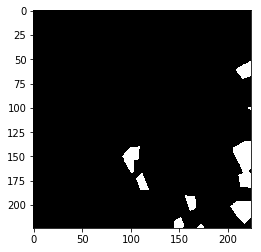

In [311]:
plt.imshow(image)

In [312]:
np.unique(prediction)

array([0, 1], dtype=uint8)

In [313]:
instances = []
for instance_path in os.listdir(ground_truth_path):
    if ".png" in instance_path and ".xml" not in instance_path:
        rgb_instance = cv.imread(os.path.join(ground_truth_path, instance_path))
        bw_instance = cv.cvtColor(rgb_instance, cv.COLOR_BGR2GRAY)
        instances.append(bw_instance)

In [314]:
instances[0].shape

(224, 224)

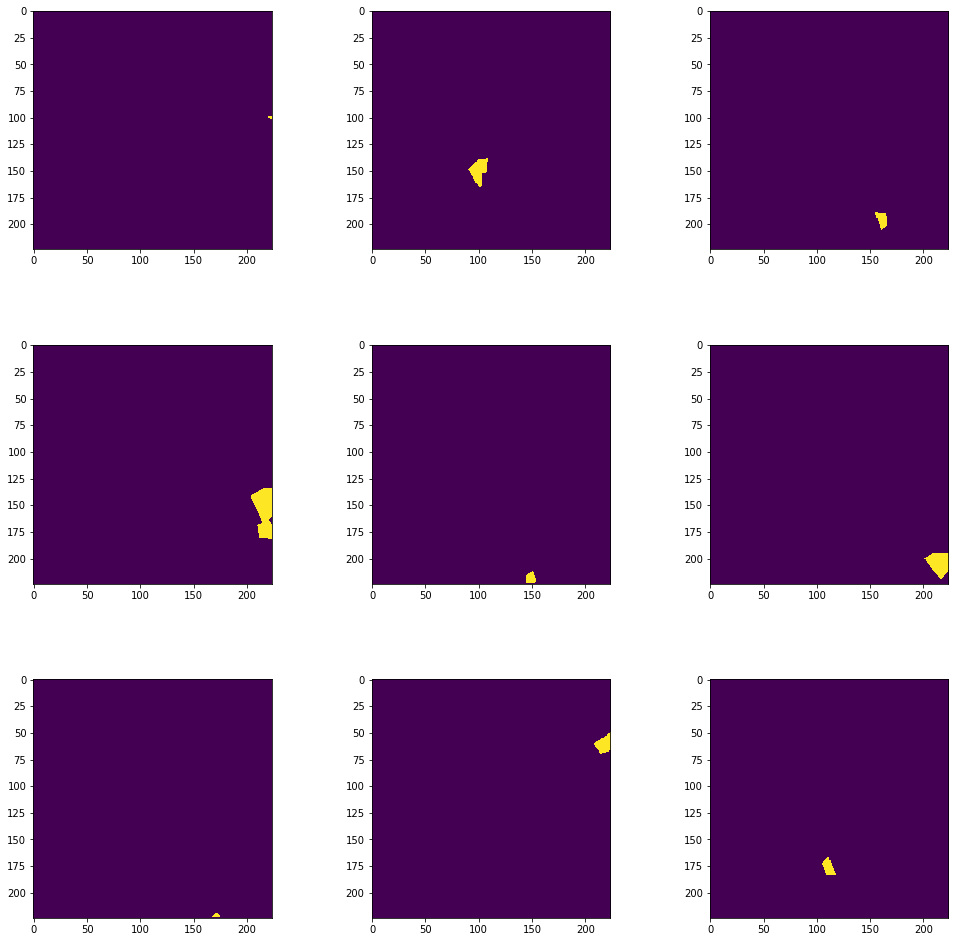

In [315]:
fig, ax = plt.subplots(figsize=(15, 15))
for i, instance in enumerate(instances):
    plt.subplot(331 + i)
    plt.imshow(instance)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.4)
plt.show()

In [254]:
np.unique(instances)

array([0, 1], dtype=uint8)

In [255]:
def watershed_transformation(prediction):
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)

    imgLaplacian = cv.filter2D(prediction, cv.CV_32F, kernel)
    sharp = np.float32(prediction)
    imgResult = sharp - imgLaplacian

    imgResult = np.clip(imgResult, 0, 255)
    imgResult = imgResult.astype('uint8')

    bw = cv.cvtColor(prediction, cv.COLOR_BGR2GRAY)
    _, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

    dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
    cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
    _, thresholded = cv.threshold(dist, 0.2, 1.0, cv.THRESH_BINARY)

    kernel1 = np.ones((3, 3), dtype=np.uint8)
    dilated = cv.dilate(thresholded, kernel1)

    dist_8u = dilated.astype('uint8')
    contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    markers = np.zeros(dilated.shape, dtype=np.int32)

    for i in range(len(contours)):
        cv.drawContours(markers, contours, i, (i + 1), -1)

    cv.circle(markers, (5, 5), 3, (255, 255, 255), -1)
    cv.watershed(imgResult, markers)

    return markers, contours


def post_processing(prediction):
    return watershed_transformation(prediction)

In [256]:
markers, contours = post_processing(prediction)

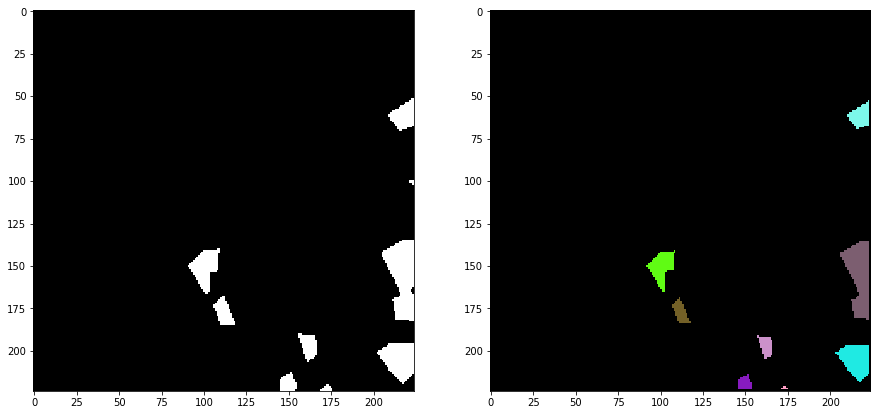

In [257]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(prediction * 255)

# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

ax[1].imshow(dst)
plt.show()

In [259]:
labels = np.unique(markers)

labels = labels[labels < 255]
labels = labels[labels > 0]

In [260]:
labels

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

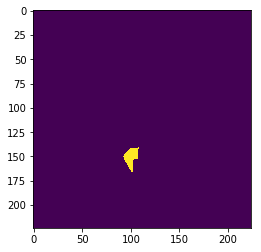

In [271]:
plt.imshow((markers == 6).astype(int))

In [261]:
len(labels)

8

In [262]:
len(instances)

9

In [263]:
iou_matrix = np.zeros((len(labels), len(instances)), dtype=np.float32)

In [265]:
def dice_coef(true_positives, false_positives, false_negatives):
    if true_positives + false_negatives + false_positives == 0:
        return 1
    return (2. * true_positives) / (2. * true_positives + false_positives + false_negatives)

def iou(y_true, y_pred, smooth=1.0):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [301]:
def compute_iou_matrix(markers, instances):
    labels = np.unique(markers)

    labels = labels[labels < 255]
    labels = labels[labels > 0]

    iou_matrix = np.zeros((len(labels), len(instances)), dtype=np.float32)

    for i, label in enumerate(labels):
        prediction_instance = (markers == label).astype(int)

        instance_ground_truth_iou = []
        for j, ground_truth_instance in enumerate(instances):
            iou_value = iou(prediction_instance, ground_truth_instance)
            iou_matrix[i,j] = iou_value
            
    return iou_matrix

In [267]:
np.round(iou_matrix, 3)

array([[0.059, 0.004, 0.008, 0.002, 0.011, 0.003, 0.5  , 0.005, 0.007],
       [0.015, 0.003, 0.006, 0.001, 0.773, 0.002, 0.013, 0.004, 0.005],
       [0.003, 0.002, 0.002, 0.001, 0.003, 0.863, 0.003, 0.002, 0.002],
       [0.011, 0.003, 0.772, 0.001, 0.006, 0.002, 0.01 , 0.004, 0.005],
       [0.01 , 0.003, 0.005, 0.001, 0.006, 0.002, 0.009, 0.003, 0.808],
       [0.005, 0.851, 0.003, 0.001, 0.003, 0.002, 0.004, 0.002, 0.003],
       [0.002, 0.001, 0.002, 0.855, 0.002, 0.001, 0.002, 0.001, 0.002],
       [0.007, 0.002, 0.004, 0.001, 0.005, 0.002, 0.006, 0.795, 0.004]],
      dtype=float32)

In [304]:
def compute_metric_at_thresholds(iou_matrix):
    dices = []
    if iou_matrix.shape == (0,0):
        return 1
    for threshold in np.arange(0.5, 1, 0.05):
        true_positives = (iou_matrix.max(axis=1) > threshold).sum()
        false_positives = (iou_matrix.max(axis=1) <= threshold).sum()
        false_negatives = (iou_matrix.max(axis=0) <= threshold).sum()
        dices.append(dice_coef(true_positives, false_positives, false_negatives))
    return np.average(dices)
    

In [269]:
dices

[0.8235294117647058,
 0.8235294117647058,
 0.8235294117647058,
 0.8235294117647058,
 0.8235294117647058,
 0.8235294117647058,
 0.47058823529411764,
 0.35294117647058826,
 0.0,
 0.0]

In [270]:
np.average(dices)

0.5764705882352941

In [317]:

def evaluate(ground_truth_path, predictions_path, pieces_info_path):
    pieces_info = pd.read_csv(pieces_info_path)

    metrics = []
    
    for i in tqdm(range(len(pieces_info))):
        piece_name = pieces_info['piece_image'][i]
        filename, file_extension = os.path.splitext(piece_name)
        
        prediction = cv.imread(os.path.join(predictions_path, filename) + ".png")
        instances = []
        
        for instance_path in os.listdir(os.path.join(ground_truth_path, filename)):
            if ".png" in instance_path and ".xml" not in instance_path:
                rgb_instance = cv.imread(os.path.join(ground_truth_path, filename, instance_path))
                bw_instance = cv.cvtColor(rgb_instance, cv.COLOR_BGR2GRAY)
                instances.append(bw_instance)
        
        markers, contours = post_processing(prediction)
        iou_matrix = compute_iou_matrix(markers, instances)
        metric = compute_metric_at_thresholds(iou_matrix)
        metrics.append(metric)
    return np.average(metrics)


In [319]:
evaluate("../test_data/masks/separated_masks/", "../test_data/masks/masks/", "../test_data/data/image_pieces.csv")

  0%|          | 0/2401 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|          | 8/2401 [00:00<00:32, 72.82it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  1%|          | 15/2401 [00:00<00:33, 71.40it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  1%|          | 21/2401 [00:00<00:38, 62.60it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  1%|          | 27/2401 [00:00<00:39, 59.64it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  1%|▏         | 33/2401 [00:00<00:40, 58.97it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  2%|▏         | 39/2401 [00:00<00:40, 58.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?i

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 13%|█▎        | 323/2401 [00:04<00:26, 77.76it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 14%|█▍        | 332/2401 [00:04<00:26, 78.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 14%|█▍        | 340/2401 [00:04<00:27, 74.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 14%|█▍        | 348/2401 [00:04<00:28, 72.70it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 15%|█▍        | 356/2401 [00:05<00:29, 68.62it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it 

0it [00:00, ?it/s]
0it [00:00, ?it/s]
 26%|██▌       | 620/2401 [00:08<00:25, 70.89it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 26%|██▌       | 628/2401 [00:08<00:24, 71.47it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 26%|██▋       | 636/2401 [00:08<00:23, 73.66it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 259.28it/s]
 27%|██▋       | 644/2401 [00:09<00:23, 74.31it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 27%|██▋       | 652/2401 [00:09<00:23, 75.05it/s]
0it [00:00, ?it/s]
1it [00:00, 215.83it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 822.09it/s]
0it [00:00, ?it/s]
5it [00:00, 263.53it/s]
0it

 37%|███▋      | 894/2401 [00:12<00:21, 70.83it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 506.31it/s]
0it [00:00, ?it/s]
2it [00:00, 209.74it/s]
0it [00:00, ?it/s]
2it [00:00, 709.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 38%|███▊      | 902/2401 [00:12<00:22, 67.16it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
13it [00:00, 205.18it/s]
0it [00:00, ?it/s]
3it [00:00, 769.79it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 38%|███▊      | 909/2401 [00:13<00:25, 58.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 38%|███▊      | 918/2401 [00:13<00:23, 64.15it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 39%|███▊      | 926/2401 [00:13<00:22, 66.94it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 49%|████▉     | 1186/2401 [00:16<00:14, 81.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
3it [00:00, 421.45it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 218.64it/s]
 50%|████▉     | 1195/2401 [00:17<00:16, 73.41it/s]
0it [00:00, ?it/s]
4it [00:00, 314.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|█████     | 1203/2401 [00:17<00:16, 71.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|█████     | 1211/2401 [00:17<00:16, 71.24it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 51%|█████     | 1219/2401 [00:17<00:16, 71.96it/s]
0it [00:00, ?it/s]
0it

0it [00:00, ?it/s]
 61%|██████    | 1469/2401 [00:21<00:11, 78.38it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
12it [00:00, 215.60it/s]
0it [00:00, ?it/s]
1it [00:00, 854.76it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 62%|██████▏   | 1478/2401 [00:21<00:13, 67.00it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 62%|██████▏   | 1486/2401 [00:21<00:13, 69.47it/s]
0it [00:00, ?it/s]
1it [00:00, 400.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
5it [00:00, 286.50it/s]
0it [00:00, ?it/s]
2it [00:00, 213.30it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 303.82it/s]
0it [00:00, ?it/s]
3it [00:00, 417.39it/s]
 62%|██████▏   | 1494/2401 [00:21<00:15, 60.39it/s]
0it [00:00, ?it/s]
1it [00:00, 164.79it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 63%|██████▎   | 1501/2401 [0

 73%|███████▎  | 1746/2401 [00:25<00:08, 73.74it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 73%|███████▎  | 1755/2401 [00:25<00:08, 75.25it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 73%|███████▎  | 1763/2401 [00:25<00:08, 76.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 486.92it/s]
0it [00:00, ?it/s]
3it [00:00, 268.75it/s]
 74%|███████▍  | 1771/2401 [00:25<00:08, 70.94it/s]
0it [00:00, ?it/s]
5it [00:00, 281.21it/s]
0it [00:00, ?it/s]
4it [00:00, 213.72it/s]
0it [00:00, ?it/s]
3it [00:00, 298.56it/s]
0it [00:00, ?it/s]
1it [00:00, 441.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 238.06it/s]
0it [00:00, ?it/s]
 74%|███████▍  | 1779/2401 [00:25<00:10, 57.52it/s]
0i

11it [00:00, 353.46it/s]
0it [00:00, ?it/s]
 84%|████████▍ | 2014/2401 [00:29<00:05, 69.32it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
3it [00:00, 219.90it/s]
0it [00:00, ?it/s]
4it [00:00, 273.74it/s]
0it [00:00, ?it/s]
1it [00:00, 591.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
3it [00:00, 227.41it/s]
0it [00:00, ?it/s]
 84%|████████▍ | 2022/2401 [00:30<00:06, 61.46it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 85%|████████▍ | 2030/2401 [00:30<00:05, 65.16it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 85%|████████▍ | 2038/2401 [00:30<00:05, 68.27it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 85%|████████▌ | 2046/2401 [00:30<00:05, 69.69it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00,

5it [00:00, 267.53it/s]
0it [00:00, ?it/s]
2it [00:00, 737.72it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 97%|█████████▋| 2317/2401 [00:34<00:01, 71.71it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 97%|█████████▋| 2325/2401 [00:34<00:01, 69.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 97%|█████████▋| 2333/2401 [00:34<00:00, 69.27it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 98%|█████████▊| 2341/2401 [00:34<00:00, 69.97it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 98%|█████████▊| 2349/2401 [00:34<00:00, 71.99it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:

0.9420584199780883